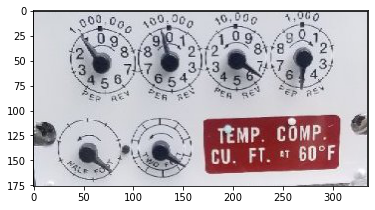

In [1]:
%matplotlib inline
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data_path = "./image1.png"

image = cv2.imread(data_path)
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Matplotlib imshow functions expects RGB, opencv defaults to BGR

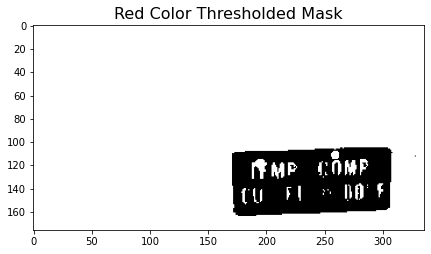

In [2]:
img_hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)  # Convert to HSV space

# Lower hues mask (0-10)
lower_red, upper_red = np.array([0,50,20]), np.array([10,255,255])
mask0 = cv2.inRange(img_hsv, lower_red, upper_red)

# Upper hues mask (170-180)
lower_red, upper_red = np.array([170,50,0]), np.array([180,255,255])
mask1 = cv2.inRange(img_hsv, lower_red, upper_red)

# Combine masks
mask = mask0 + mask1
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title("Red Color Thresholded Mask", fontsize=16)
ax.imshow(mask, cmap="Greys")

In [3]:
channel_means = cv2.mean(img_hsv, mask=~mask)  # Invert mask to sample only the rectangle
print(channel_means)
print("Mean value (brightness) in red rectangle is %.2f" % (channel_means[2],))

(114.00093351114498, 15.105848733092017, 197.92345208611164, 0.0)
Mean value (brightness) in red rectangle is 197.92


In [4]:
# RETR_EXTERNAL is the contour retrieval mode, CHAIN_APPROX_NONE is the contour approximation method
# Output is a Python list of all the found contours, each one is a Numpy array of (x,y) coordinates
(contours,_) = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [5]:
# For each contour check object area with a bounding box, if area above threshold assume we found the rectangle
imcopy = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).copy()
for contour in contours:
    (x,y,w,h) = cv2.boundingRect(contour)
    
    # A threshold area of 1000 works for all the images in the data set (which can have different resolutions)
    if w*h > 1000:
        rect = cv2.minAreaRect(contour)  # Fit a rotated rectangle bounding box to the contour
        print("Rotated rectangle found at center point" , np.round(rect[0]), "with angle", np.round(rect[2], 2), "degrees.")
        print("Rotated rectangle width is %i and area is %i" % (np.round(min(rect[1][0], rect[1][1])), np.round(rect[1][0]*rect[1][1])))
        rotrect_angle, rect_width, rect_area = rect[2], min(rect[1][0], rect[1][1]), rect[1][0]*rect[1][1]
        print(rect[0])
        # Draw the rotated rectangle (see https://stackoverflow.com/questions/11779100/python-opencv-box2d)
        box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
        box = np.int0(box)
        cv2.drawContours(imcopy,[box], 0, (0,255,0), 1)

Rotated rectangle found at center point [240. 134.] with angle 87.9 degrees.
Rotated rectangle width is 55 and area is 7628
(239.88609313964844, 133.55296325683594)


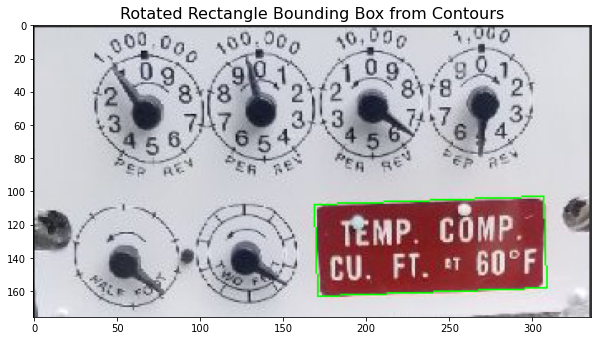

In [6]:
# See rotated rectangle superimposed on image
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Rotated Rectangle Bounding Box from Contours", fontsize=16)
ax.imshow(imcopy)

In [7]:
def get_real_angle(rotrect_angle):
    if rotrect_angle <= -45:
        real_angle_deg = 90 + rotrect_angle
    else:
        real_angle_deg = rotrect_angle
    return real_angle_deg

In [8]:
def find_rotated_rect(img_hsv, rect_area_thresh=1000):

    # Lower hues mask (0-10)
    lower_red, upper_red = np.array([0,50,50]), np.array([10,255,255])
    mask0 = cv2.inRange(img_hsv, lower_red, upper_red)

    # Upper hues mask (170-180)
    lower_red, upper_red = np.array([170,50,50]), np.array([180,255,255])
    mask1 = cv2.inRange(img_hsv, lower_red, upper_red)

    # Combine masks
    mask = mask0 + mask1
    
    # RETR_EXTERNAL is the contour retrieval mode, CHAIN_APPROX_NONE is the contour approximation method
    # Output is a Python list of all the found contours, each one is a Numpy array of (x,y) coordinates
    (contours,_) = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # For each contour check object area with a bounding box, if area above threshold assume we found the rectangle
    imcopy = image.copy()
    for contour in contours:
        (x,y,w,h) = cv2.boundingRect(contour)
        if w*h > rect_area_thresh:
            rect = cv2.minAreaRect(contour)  # Fit a rotated rectangle bounding box to the contour
            print("Rotated rectangle found at center point" , np.round(rect[0]), "with angle", np.round(rect[2], 2), "degrees.")
            print("Rotated rectangle area is" , np.round(rect[1][0]*rect[1][1]))
            rotrect_angle, rect_width, rect_area = rect[2], min(rect[1][0], rect[1][1]), rect[1][0]*rect[1][1]
    
    return rect, rotrect_angle, rect_area, rect_width

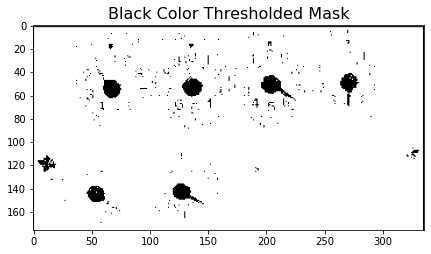

In [9]:
# Black HSV mask
lower_black, upper_black = np.array([0, 0, 0]), np.array([180, 255, 65])
mask = cv2.inRange(img_hsv, lower_black, upper_black)
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title("Black Color Thresholded Mask", fontsize=16)
ax.imshow(mask, cmap="Greys")

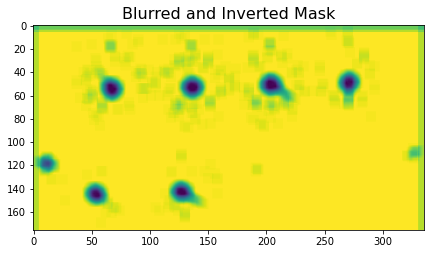

In [10]:
# Apply a Gaussian Blur to the inverted mask
blurred = cv2.blur(~mask, (9, 9))
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title("Blurred and Inverted Mask", fontsize=16)
ax.imshow(blurred)

In [11]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
 
# Adjust parameters for determining blob stability/repeatability
params.minThreshold = 0;
params.maxThreshold = 100;
params.minRepeatability = 1
 
# Filter by Area.
params.filterByArea = True
params.minArea = 0.75 * 118 * rect_area / 8079  # rect_area is found above during red rectangle detection
 
# Filter by Circularity
# params.filterByCircularity = True
# params.minCircularity = 0.5
 
# Create a detector with the parameters
detector = cv2.SimpleBlobDetector_create(params)

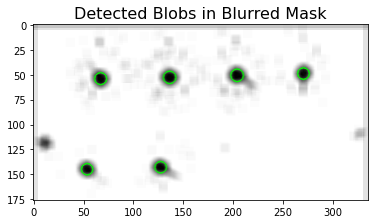

In [12]:
# Detect blobs
keypoints = detector.detect(blurred)

# Draw detected blobs as green circles on the blurred mask
imcopy = image.copy()
im_with_keypoints = cv2.drawKeypoints(blurred, keypoints, 
                                      np.array([]), (0,255,0), 
                                      cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)  # ensures circle size corresponds to blob size
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Detected Blobs in Blurred Mask", fontsize=16)
ax.imshow(im_with_keypoints)

In [13]:
image = cv2.imread(data_path)
img_hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)  # Convert to HSV space

In [14]:
# Increment upper bound for "value" (brightness) until we find 6 blobs
n_blobs = 0
v_upper = 25
while n_blobs < 6 and v_upper < 100:
    
    # Black HSV mask
    lower_black, upper_black = np.array([0, 0, 0]), np.array([180, 255, v_upper])
    mask = cv2.inRange(img_hsv, lower_black, upper_black)
    
    # Apply a Gaussian Blur to the inverted mask
    blurred = cv2.blur(~mask, (9, 9))

    # Detect blobs
    keypoints = detector.detect(blurred)
    n_blobs = len(keypoints)
    v_upper += 5

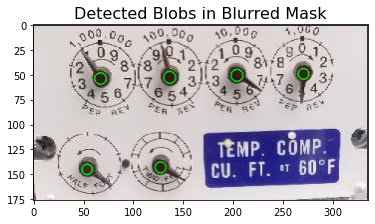

In [15]:
# Draw detected blobs as green circles on the original image
imcopy = image.copy()
im_with_keypoints = cv2.drawKeypoints(imcopy, keypoints, 
                                      np.array([]), (0,255,0), 
                                      cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)  # ensures circle size corresponds to blob size
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Detected Blobs in Blurred Mask", fontsize=16)
ax.imshow(im_with_keypoints)

In [16]:
# Extract coordinates of gauge centers in the (column index, row index) convention
gauge_center_coords = []
for kp in keypoints:
    gauge_center_coords.append((np.int(kp.pt[0]), np.int(kp.pt[1])))
    
# Sort the gauge's by center coordinates
gauge_center_coords.sort(key=lambda x: x[1])
gauge_center_coords[0:4] = sorted(gauge_center_coords[0:4], key=lambda x: x[0])
gauge_center_coords[4:] = sorted(gauge_center_coords[4:], key=lambda x: x[0])
print("Gauge centers found at coordinates: ", gauge_center_coords)

Gauge centers found at coordinates:  [(67, 54), (136, 52), (204, 50), (270, 49), (53, 144), (127, 142)]


C:\Users\Kunnu\AppData\Local\Temp/ipykernel_13504/2789644963.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gauge_center_coords.append((np.int(kp.pt[0]), np.int(kp.pt[1])))


In [17]:
def find_gauge_centers(img_hsv, rect_area):
    
    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()
    # Adjust parameters for determining blob stability/repeatability
    params.minThreshold = 0;
    params.maxThreshold = 100;
    params.minRepeatability = 1
    # Filter by Area.
    params.filterByArea = True
    params.minArea = 0.75 * 118 * rect_area / 8079  # rect_area is found above during red rectangle detection
    # Filter by Circularity.
#     params.filterByCircularity = True
#     params.minCircularity = 0.5
    detector = cv2.SimpleBlobDetector_create(params)
    
    # Increment upper bound for "value" (brightness) until we find 6 blobs
    n_blobs = 0
    v_upper = 25
    while n_blobs < 6:
        # Black HSV mask
        lower_black, upper_black = np.array([0, 0, 0]), np.array([180, 255, v_upper])
        mask = cv2.inRange(img_hsv, lower_black, upper_black)
        # Apply a Gaussian Blur to the inverted mask
        blurred = cv2.blur(~mask, (9, 9))
        # Detect blobs
        keypoints = detector.detect(blurred)
        n_blobs = len(keypoints)
        v_upper += 5
    
    # Extract the coordinates of gauge centers in the (column index, row index) convention
    gauge_center_coords = []
    for kp in keypoints:
        gauge_center_coords.append((np.int(kp.pt[0]), np.int(kp.pt[1])))
    
    # Sort the gauge's by center coordinates
    gauge_center_coords.sort(key=lambda x: x[1])
    gauge_center_coords[0:4] = sorted(gauge_center_coords[0:4], key=lambda x: x[0])
    gauge_center_coords[4:] = sorted(gauge_center_coords[4:], key=lambda x: x[0])
    print("Gauge centers found at coordinates: ", gauge_center_coords)
    
    return keypoints, gauge_center_coords

In [18]:
image = cv2.imread(data_path)
img_hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)  # Convert to HSV space

In [19]:
# Pick out the first gauge to work on
circ_col, circ_row = gauge_center_coords[0]

In [20]:
# Extract rotated rectangle parameters
rotrect_angle, rect_width, rect_area = rect[2], min(rect[1][0], rect[1][1]), rect[1][0]*rect[1][1]
rect_col, rect_row = rect[0] 

# Determine good size for circles to be drawn around gauges
circ_rad = np.int(30 * rect_width / 57)

# Draw a circle centered around gauge center point, extract pixel indices and colors on circle perimeter
blank = np.zeros(image.shape[:2], dtype=np.uint8)
cv2.circle(blank, (circ_col, circ_row), circ_rad, 255, thickness=1)  # Draw function wants center point in (col, row) order like coordinates
ind_row, ind_col = np.nonzero(blank)
b = image[:, :, 0][ind_row, ind_col]
g = image[:, :, 1][ind_row, ind_col]
r = image[:, :, 2][ind_row, ind_col]
colors = list(zip(b, g, r))

C:\Users\Kunnu\AppData\Local\Temp/ipykernel_13504/3025397612.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  circ_rad = np.int(30 * rect_width / 57)


In [21]:
# "reverse" the row indices to get a right-handed frame of reference with origin in bottom left of image
ind_row_rev = [image.shape[0] - row for row in ind_row]
circ_row_rev = image.shape[0] - circ_row
rect_row_rev = image.shape[0] - rect_row

# Convert from indexes in (row, col) order to coordinates in (col, row) order
circ_x, circ_y = circ_col, circ_row_rev
original_coord = list(zip(ind_col, ind_row_rev))
rect_x, rect_y = rect_col, rect_row_rev

# Rotate coords about rectangle center in order to identify topmost pixel of gauges
temp_x, temp_y = [x - rect_x for x in ind_col], [y - rect_y for y in ind_row_rev]  # Translate from rectangle center point
angle_deg = get_real_angle(rotrect_angle)
theta = angle_deg * (np.pi/180)
rotated = []
for (x, y) in list(zip(temp_x, temp_y)):
    rotated.append(((x*np.cos(theta) - y*np.sin(theta)) + rect_x, 
                    (y*np.cos(theta) + x*np.sin(theta)) + rect_y))  # Rotate about 0,0 then reverse translation from rectangle center point
top_yval = max([y for (x,y) in rotated])
top_pixel = [(x, y) for (x, y) in rotated if y == top_yval][0]

# Translate coords from gauge centers in order to compute angle between points on the perimeter
translated = []
for (x, y) in original_coord:
    translated.append((x - circ_x, y - circ_y))

In [22]:
# Construct dataframe holding various coordinate representations and pixel values
df = pd.DataFrame({"indices":list(zip(ind_col, ind_row)), "orig":original_coord, "rot": rotated, "trans": translated, "color": colors})

# Identify the pixel which is the topmost point of the circle when properly rotated
df["top_pixel"] = (df["rot"] == top_pixel)
top_trans_pix = df.loc[df["top_pixel"], "trans"].values[0]
df.head()

,indices,orig,rot,trans,color,top_pixel
0,"(67, 25)","(67, 151)","(125.08483207847705, -126.35467382783679)","(0, 29)","(223, 208, 205)",False
1,"(60, 26)","(60, 150)","(125.82823711181356, -133.38655472532147)","(-7, 28)","(217, 208, 205)",False
2,"(61, 26)","(61, 150)","(125.86479802509615, -132.38722329900688)","(-6, 28)","(221, 212, 209)",False
3,"(62, 26)","(62, 150)","(125.90135893837872, -131.38789187269228)","(-5, 28)","(216, 207, 204)",False
4,"(63, 26)","(63, 150)","(125.9379198516613, -130.3885604463777)","(-4, 28)","(212, 197, 194)",False


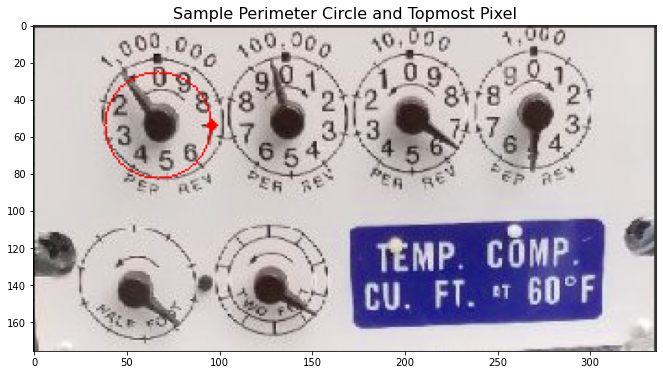

In [23]:
# Visualize the circle and topmost circle pixel
imcopy = image.copy()
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_title("Sample Perimeter Circle and Topmost Pixel", fontsize=16)
cv2.circle(imcopy, (circ_col, circ_row), circ_rad, 255, thickness=1)  # Draw circle around gauge center point
top_orig_pix =  df.loc[df["top_pixel"], "indices"].values[0]  # Get indices for "topmost" pixel on circle after rotation
cv2.circle(imcopy, top_orig_pix, 1, 255, thickness=3)  # Draw topmost pixel
ax.imshow(imcopy)

In [24]:
# Angle and "clock angle" between the topmost pixel and other perimeter pixels
angles = []
for vec in df["trans"].values:
    angles.append((180 / np.pi) * np.arccos(np.dot(top_trans_pix, vec) / (np.linalg.norm(top_trans_pix) * np.linalg.norm(vec))))
df["angle"] = angles
df["clock_angle"] = df["angle"] + (-2*df["angle"] + 360)*(df["trans"].apply(lambda x: x[0] < 0)).astype(int)

In [25]:
# Draw lines between gauge center and perimeter pixels and compute mean and std dev of pixels along lines 
stds = []
means = []
gray_values = []
for (pt_col, pt_row_rev) in df["orig"].values:
    pt_row = -(pt_row_rev - image.shape[0])
    blank = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.line(blank, (circ_col, circ_row), (pt_col, pt_row), 255, thickness=2)  # Draw function wants center point in (col, row) order like coordinates
    ind_row, ind_col = np.nonzero(blank)
    b = image[:, :, 0][ind_row, ind_col]
    g = image[:, :, 1][ind_row, ind_col]
    r = image[:, :, 2][ind_row, ind_col]
    grays = (b.astype(int) + g.astype(int) + r.astype(int))/3  # Compute grayscale with naive equation
    stds.append(np.std(grays))
    means.append(np.mean(grays))
    gray_values.append(grays)

df["stds"] = stds
df["means"] = means
df["gray_values"] = gray_values

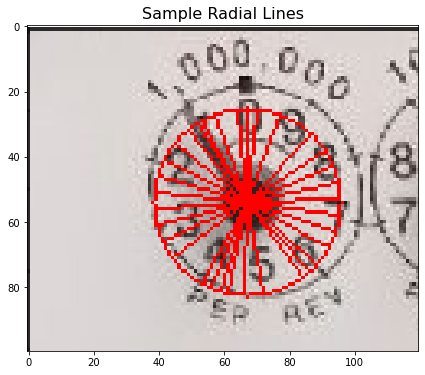

In [26]:
# Visualize a sample of the radial lines
imcopy = image.copy()
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_title("Sample Radial Lines", fontsize=16)

# Draw every fifth radial line
for (pt_col, pt_row_rev) in df["orig"].values[::5]:
    pt_row = -(pt_row_rev - image.shape[0])
    cv2.line(imcopy, (circ_col, circ_row), (pt_col, pt_row), 255, thickness=1)  # Draw function wants center point in (col, row) order like coordinates

cv2.circle(imcopy, (circ_col, circ_row), circ_rad, 255, thickness=1)  # Draw circle around gauge center point
ax.imshow(imcopy[0:100, 0:120])

Text(0.5, 1.0, 'Locating Gauge Needle from Radial Line Pixel Values')

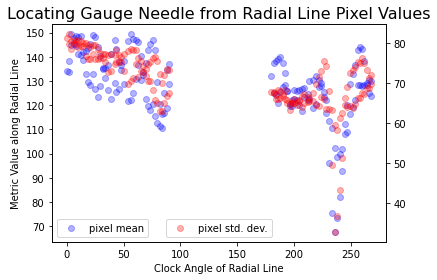

In [27]:
# Plot mean pixel value as a function of needle "clock angle" (zero degrees is 12 o'clock)
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.scatter(df["clock_angle"], df["stds"], color="r", alpha=0.3, label="pixel std. dev.")
ax.scatter(df["clock_angle"], df["means"], label="pixel mean", color="b", alpha=0.3)
ax2.legend(loc="lower center")
ax.legend(loc="lower left")
ax.set_xlabel("Clock Angle of Radial Line")
ax.set_ylabel("Metric Value along Radial Line")
ax.set_title("Locating Gauge Needle from Radial Line Pixel Values", fontsize=16)

In [28]:
# What angle gives us the minimum in mean pixel value (i.e. darkest average of pixel intensity)
min_mean = df["means"].min()
needle_angle = df.loc[df["means"] == min_mean, "clock_angle"].values[0]
print("Darkest average pixel value (i.e. the needle) is found at clock angle %.2f degrees" % (needle_angle,))

Darkest average pixel value (i.e. the needle) is found at clock angle 236.31 degrees


Text(0.5, 1.0, 'Distribution of Pixel Values')

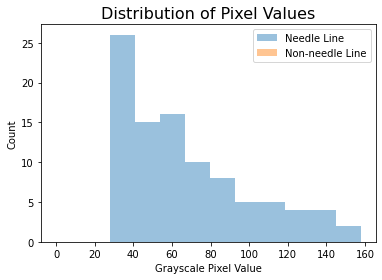

In [29]:
# Plot histogram of pixel values for needle line and non-needle line
fig, ax = plt.subplots()

grays = df.loc[df["means"].values == min_mean, "gray_values"].values
ax.hist(grays, alpha=0.45, label="Needle Line")

grays = df.loc[np.round(df["clock_angle"].values) == 158, "gray_values"].values
ax.hist(grays, alpha=0.45, label="Non-needle Line")

ax.legend()
ax.set_xlabel("Grayscale Pixel Value")
ax.set_ylabel("Count")
ax.set_title("Distribution of Pixel Values", fontsize=16)

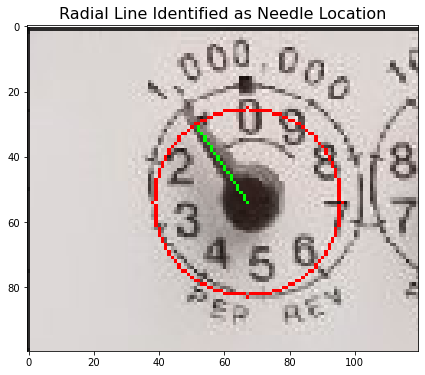

In [30]:
# Visualize the "needle" radial lines
imcopy = image.copy()
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_title("Radial Line Identified as Needle Location", fontsize=16)

(pt_col, pt_row) = df.loc[df["means"] == min_mean, "indices"].values[0]
cv2.line(imcopy, (circ_col, circ_row), (pt_col, pt_row), (0, 255, 0), thickness=1)  # Draw needle radial line
cv2.circle(imcopy, (circ_col, circ_row), circ_rad, 255, thickness=1)  # Draw circle around gauge center point
ax.imshow(imcopy[0:100, 0:120])

In [31]:
readout_conventions = ["CCW", "CW", "CCW", "CW", "CW", "CW"]
convention = readout_conventions[0]  # Counterclockwise readout for Gauge #1
if convention == "CW":
    print("Gauge #1 reading is %.2f" % (10*needle_angle/360,))
else:
    print("Gauge #1 reading is %.2f" % (10 - (10*needle_angle/360),))

Gauge #1 reading is 3.44


In [32]:
def find_needle(image, circ_col, circ_row, rect):
        
    # Extract rotated rectangle parameters
    rotrect_angle, rect_width, rect_area = rect[2], min(rect[1][0], rect[1][1]), rect[1][0]*rect[1][1]
    rect_col, rect_row = rect[0] 
    
    # Determine good size for circles to be drawn around gauges
    circ_rad = np.int(30 * rect_width / 57)
    
    # Draw circle centered around gauge center point, extract pixel indices and colors on circle perimeter
    blank = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.circle(blank, (circ_col, circ_row), circ_rad, 255, thickness=1)  # Draw function wants center point in (col, row) order like coordinates
    ind_row, ind_col = np.nonzero(blank)
    b = image[:, :, 0][ind_row, ind_col]
    g = image[:, :, 1][ind_row, ind_col]
    r = image[:, :, 2][ind_row, ind_col]
    colors = list(zip(b, g, r))

    # "reverse" the row indices to get a right-handed frame of reference with origin in bottom left of image
    ind_row_rev = [image.shape[0] - row for row in ind_row]
    circ_row_rev = image.shape[0] - circ_row
    rect_row_rev = image.shape[0] - rect_row
    
    # Convert from indexes in (row, col) order to coordinates in (col, row) order
    circ_x, circ_y = circ_col, circ_row_rev
    original_coord = list(zip(ind_col, ind_row_rev))
    rect_x, rect_y = rect_col, rect_row_rev
    
    # Rotate coords about rectangle center in order to identify topmost pixel of gauges
    temp_x, temp_y = [x - rect_x for x in ind_col], [y - rect_y for y in ind_row_rev]  # Translate from rectangle center point
    angle_deg = get_real_angle(rotrect_angle)
    theta = angle_deg * (np.pi/180)
    rotated = []
    for (x, y) in list(zip(temp_x, temp_y)):
        rotated.append(((x*np.cos(theta) - y*np.sin(theta)) + rect_x, 
                        (y*np.cos(theta) + x*np.sin(theta)) + rect_y))  # Rotate about 0,0 then reverse translation from rectangle center point
    top_yval = max([y for (x,y) in rotated])
    top_pixel = [(x, y) for (x, y) in rotated if y == top_yval][0]
    
    # Translate coords from gauge centers in order to compute angle between points on the perimeter
    translated = []
    for (x, y) in original_coord:
        translated.append((x - circ_x, y - circ_y))

    # Construct dataframe holding various coordinate representations and pixel values
    df = pd.DataFrame({"indices":list(zip(ind_col, ind_row)), "orig":original_coord, "rot": rotated, "trans": translated, "color": colors})

    # Identify the pixel which is the topmost point of the circle when properly rotated
    df["top_pixel"] = (df["rot"] == top_pixel)
    top_trans_pix = df.loc[df["top_pixel"], "trans"].values[0]

    # Angle and "clock angle" between the topmost pixel and other perimeter pixels
    angles = []
    for vec in df["trans"].values:
        angles.append((180 / np.pi) * np.arccos(np.dot(top_trans_pix, vec) / (np.linalg.norm(top_trans_pix) * np.linalg.norm(vec))))
    df["angle"] = angles
    df["clock_angle"] = df["angle"] + (-2*df["angle"] + 360)*(df["trans"].apply(lambda x: x[0] < 0)).astype(int)

    # Draw lines between gauge center and perimeter pixels and compute mean and std dev of pixels along lines 
    stds = []
    means = []
    gray_values = []
    for (pt_col, pt_row_rev) in df["orig"].values:
        pt_row = -(pt_row_rev - image.shape[0])
        blank = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.line(blank, (circ_col, circ_row), (pt_col, pt_row), 255, thickness=2)  # Draw function wants center point in (col, row) order like coordinates
        ind_row, ind_col = np.nonzero(blank)
        b = image[:, :, 0][ind_row, ind_col]
        g = image[:, :, 1][ind_row, ind_col]
        r = image[:, :, 2][ind_row, ind_col]
        grays = (b.astype(int) + g.astype(int) + r.astype(int))/3  # Compute grayscale with naive equation
        stds.append(np.std(grays))
        means.append(np.mean(grays))
        gray_values.append(grays)

    df["stds"] = stds
    df["means"] = means
    df["gray_values"] = gray_values

    # Find needle clock angle
    min_mean = df["means"].min()
    needle_angle = df.loc[df["means"] == min_mean, "clock_angle"].values[0]  # Find needle angle
    
    return df, needle_angle

In [33]:
def read_gauge(angle, convention):
    # Gauge readout according to convention
    if convention == "CW":
        readout = 10*needle_angle/360
    else:
        readout = 10 - (10*needle_angle/360)
    return readout

In [34]:
readout_conventions = ["CCW", "CW", "CCW", "CW", "CW", "CW"]

Rotated rectangle found at center point [240. 134.] with angle 87.9 degrees.
Rotated rectangle area is 7628.0
Gauge centers found at coordinates:  [(67, 54), (136, 52), (204, 50), (270, 49), (53, 144), (127, 142)]
Gauge #1 reading is 3.44
Gauge #2 reading is 7.16
Gauge #3 reading is 9.06


C:\Users\Kunnu\AppData\Local\Temp/ipykernel_13504/4293861268.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gauge_center_coords.append((np.int(kp.pt[0]), np.int(kp.pt[1])))
C:\Users\Kunnu\AppData\Local\Temp/ipykernel_13504/738704327.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curren

Gauge #4 reading is 7.44
Gauge #5 reading is 0.94
Gauge #6 reading is 0.81


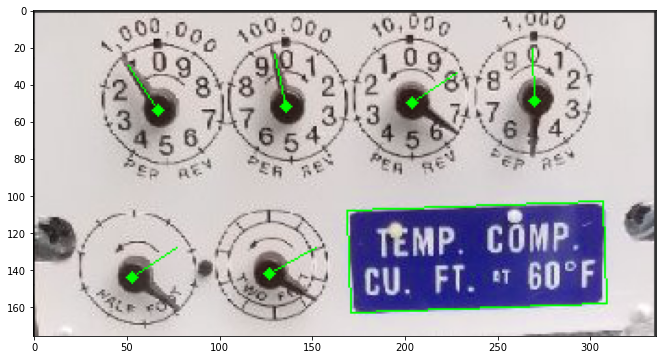

In [35]:
image = cv2.imread(data_path)
imcopy = image.copy()
img_hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)  # Convert to HSV space

# Find rectangle panel and gauge centers
rect, rotrect_angle, rect_area, rect_width = find_rotated_rect(img_hsv, rect_area_thresh=1000)
keypoints, gauge_centers = find_gauge_centers(img_hsv, rect_area)

# For each gauge, get gauge readout and visualize results
for i, ((c, r), convention) in enumerate(zip(gauge_centers, readout_conventions)):
    
    # Find needle angle
    df, needle_angle = find_needle(image=image, circ_col=c, circ_row=r, rect=rect)
    
    # Draw needle radial line and gauge center point
    (pt_col, pt_row) = df.loc[df["clock_angle"] == needle_angle, "indices"].values[0]
    cv2.line(imcopy, (c, r), (pt_col, pt_row), (0, 255, 0), thickness=1)  # Draw needle radial line
    cv2.circle(imcopy, (c, r), 1, (0, 255, 0), thickness=3)  # Draw function wants center point in (col, row) order like coordinates
    
    # Gauge readout according to convention
    print("Gauge #%i reading is %.2f" % (i+1, read_gauge(needle_angle, convention)))

# Draw the rotated rectangle (see https://stackoverflow.com/questions/11779100/python-opencv-box2d)
cv2.drawContours(imcopy,[np.int0(cv2.boxPoints(rect))], 0, (0,255,0), 1)
fig, ax = plt.subplots(figsize=(18, 6))
ax.imshow(imcopy)

Rotated rectangle found at center point [240. 134.] with angle 87.9 degrees.
Rotated rectangle area is 7628.0
Gauge centers found at coordinates:  [(67, 54), (136, 52), (204, 50), (270, 49), (53, 144), (127, 142)]
Gauge #1 reading is 6.56
Gauge #2 reading is 7.16
Gauge #3 reading is 0.94


C:\Users\Kunnu\AppData\Local\Temp/ipykernel_13504/4293861268.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gauge_center_coords.append((np.int(kp.pt[0]), np.int(kp.pt[1])))
C:\Users\Kunnu\AppData\Local\Temp/ipykernel_13504/738704327.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curren

Gauge #4 reading is 7.44
Gauge #5 reading is 0.94
Gauge #6 reading is 0.81


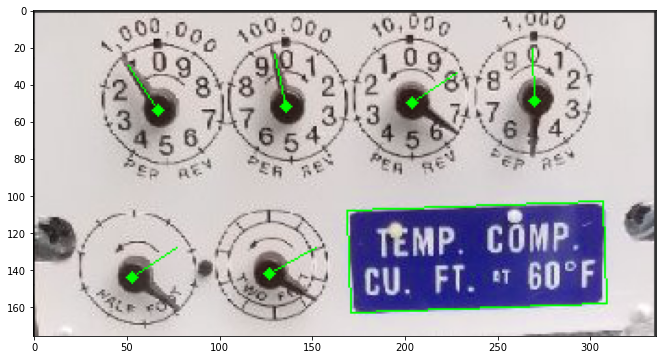

In [36]:
image = cv2.imread(data_path)
imcopy = image.copy()
img_hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)  # Convert to HSV space

rect, rotrect_angle, rect_area, rect_width = find_rotated_rect(img_hsv, rect_area_thresh=1000)
keypoints, gauge_centers = find_gauge_centers(img_hsv, rect_area)

# For each gauge, find needle reading
for i, ((c, r), readout) in enumerate(zip(gauge_centers, readout_conventions)):
    df, needle_angle = find_needle(image=image, circ_col=c, circ_row=r, rect=rect)
    
    # Draw needle radial line and gauge center point
    (pt_col, pt_row) = df.loc[df["clock_angle"] == needle_angle, "indices"].values[0]
    cv2.line(imcopy, (c, r), (pt_col, pt_row), (0, 255, 0), thickness=1)  # Draw needle radial line
    cv2.circle(imcopy, (c, r), 1, (0, 255, 0), thickness=3)  # Draw function wants center point in (col, row) order like coordinates
    
    # Gauge readout according to convention
    print("Gauge #%i reading is %.2f" % (i+1, read_gauge(needle_angle, convention)))

# Draw the rotated rectangle (see https://stackoverflow.com/questions/11779100/python-opencv-box2d)
cv2.drawContours(imcopy,[np.int0(cv2.boxPoints(rect))], 0, (0,255,0), 1)
fig, ax = plt.subplots(figsize=(18, 6))
ax.imshow(imcopy)